In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [3]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/cermine')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/cermine/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [6]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0719 23:33:33.452626 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 23:33:34.298109 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 23:34:08.545078 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 23:34:09.022247 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0719 23:34:09.028238 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 9


# Train model 

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0719 23:36:26.048782 13440 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 23:36:26.132881 13440 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1728716 samples, validate on 216089 samples
Epoch 1/10
1728716/1728716 [==============================] - 287s 166us/step - loss: 0.2086 - acc: 0.9896 - val_loss: 0.0806 - val_acc: 0.9899
Epoch 2/10
1728716/1728716 [==============================] - 269s 156us/step - loss: 0.0742 - acc: 0.9901 - val_loss: 0.0695 - val_acc: 0.9899
Epoch 3/10
1728716/1728716 [==============================] - 259s 150us/step - loss: 0.0617 - acc: 0.9901 - val_loss: 0.0553 - val_acc: 0.9899
Epoch 4/10
1728716/1728716 [==============================] - 286s 165us/step - loss: 0.0474 - acc: 0.9901 - val_loss: 0.0410 - val_acc: 0.9899
Epoch 5/10
1728716/1728716 [==============================] - 272s 157us/step - loss: 0.0345 - acc: 0.9901 - val_loss: 0.0300 - val_acc: 0.9899
Epoch 6/10
1728716/1728716 [==============================] - 271s 157us/step - loss: 0.0273 - acc: 0.9901 - val_loss: 0.0255 - val_acc: 0.9899
Epoch 7/10
1728716/1728716 [==============================] - 261s 151us/step - los

# Learning curves

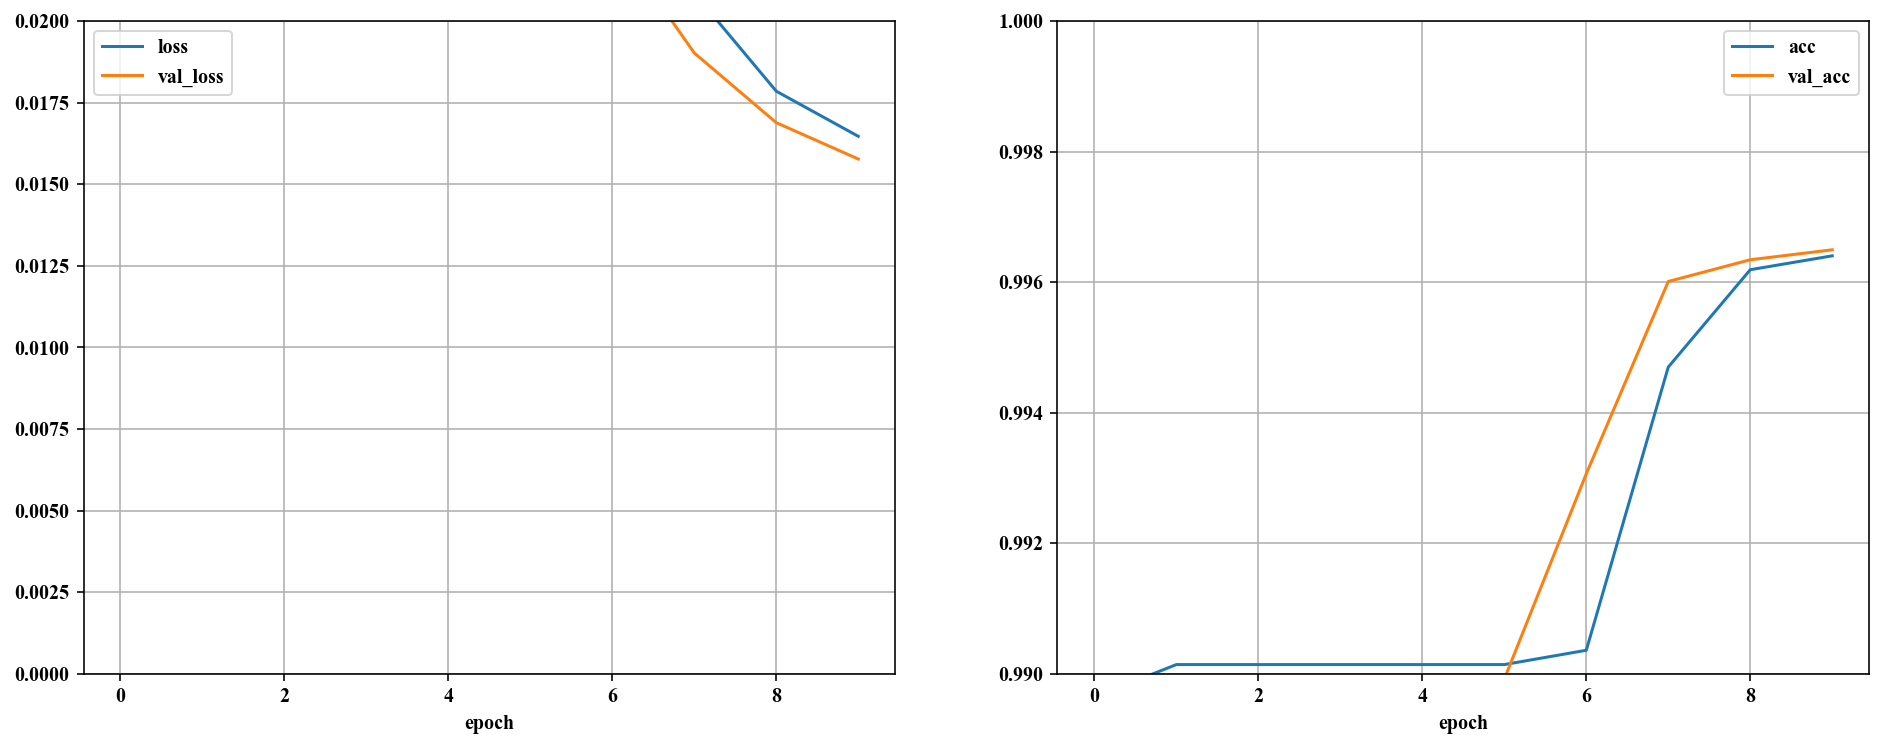

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [9]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213910
           1       0.97      0.67      0.79      2179

   micro avg       1.00      1.00      1.00    216089
   macro avg       0.98      0.84      0.90    216089
weighted avg       1.00      1.00      1.00    216089

[[213868     42]
 [   715   1464]]


In [10]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
38329,98a28ee8-aa64-11e9-a88e-68f7283d3e4e,"Chromatographic <unk> , methods and applications by Stig G",Frank,"Chichester ( 1988 ) ISBN <unk> , Journal of High Resolution Chromatography",1989,989e6f78-aa64-11e9-9875-68f7283d3e4e,<unk>,"Frank , Crossref","Chichester ( 1988 ) ISBN <unk> , Journal of High Resolution Chromatography",1989
10421,c194b3ac-aa64-11e9-a3b1-68f7283d3e4e,<unk> e <unk> en Cuba,"<unk> , L.","<unk> Revista Iberoamericana Universitaria En Ambiente , Sociedad y <unk>",2015,c1926950-aa64-11e9-9473-68f7283d3e4e,"<unk> e <unk> en <unk> ( , 1 : 1 ambiens Revista Iberoamericana Universitaria en Ambiente",<unk>,Sociedad y <unk>,2015
21219,c1485b38-aa64-11e9-b772-68f7283d3e4e,<unk>,<unk>,Journal of Development Economics,1985,c1421880-aa64-11e9-ad8f-68f7283d3e4e,<unk>,Announcement,Journal of Development Economics,1985
127781,9a52b062-aa64-11e9-899d-68f7283d3e4e,<unk>,"<unk> , Do <unk> de Disclosure No Custo de Capital Das Empresas Brasileiras de Capital Aberto Do Setor de <unk>",<unk> da <unk>,2017,9a5856b8-aa64-11e9-af73-68f7283d3e4e,"Souza , Impacto do <unk> de","<unk> , J. S. , Albuquerque , A , Disclosure no Custo de Capital das Empresas Brasileiras de Capital Aberto",<unk> da <unk>,2017
46172,adae577e-aa64-11e9-8000-68f7283d3e4e,Changes in blood acetaldehyde levels after ethanol administration in alcoholics,"Takase , S. , Yasuhara , M. , Takada , A. , Ueshima , Y.","<unk> Alcohol , <unk>",1990,adaa3802-aa64-11e9-8279-68f7283d3e4e,Changes in blood acetaldehyde levels after ethanol administration in alcoholics,"Takase , S.",alcohol. 7,"1990, 1990, 37ÃÂ¢"


# Save model and histories 

In [11]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-cermine.csv', index=False)
model.save_weights('../data/models/crossref-cermine-base-1-num-null')

# Test model 

In [12]:
model.load_weights('../data/models/crossref-cermine-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99665   0.99976   0.99821    213922
           1    0.96602   0.66882   0.79041      2168

   micro avg    0.99644   0.99644   0.99644    216090
   macro avg    0.98134   0.83429   0.89431    216090
weighted avg    0.99635   0.99644   0.99612    216090

[[213871     51]
 [   718   1450]]
